In [1]:
import numpy as np 
import pandas as pd
from pathlib import Path


%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import src.util_analysis as util_analysis

In [ ]:
# So that we can edit the text in illustrator
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("all_figures_output/")
fig_out_dir.mkdir(parents=True, exist_ok=True)

## Load pre-processed model simulation

In [11]:
df_for_agg = pd.read_csv("data/figure_5_train_and_random_model_activation_correlations_at_azims.csv")

In [12]:
df_for_agg.group.value_counts()

group
feature-gain      624
random weights    624
Name: count, dtype: int64

In [13]:
import re
# Get layer order per model. Will have from [cochleagram, norm_coch_rep, ..., attnfc, relufc]
layer_order_dict = {}

def sort_layers(layers):
    # Separate layers into categories
    coch_layers = ['cochleagram', 'norm_coch_rep']
    fc_layers = ['attnfc', 'relufc']
    n_blocks = len([layer for layer in layers if ('relu' in layer and 'fc' not in layer)])

    block_order = []
    for block_ix in range(n_blocks):
        block_order.append(f'attn{block_ix}')
        block_order.append(f'conv{block_ix}_ln')
        block_order.append(f'conv{block_ix}_relu')
        block_order.append(f'hann_pool_{block_ix}')

    # Combine all categories in the desired order
    return coch_layers + block_order + fc_layers


def get_int(val):
    return int(re.search(r'\d+', val).group())

for model in df_for_agg['model_name'].unique():
    layers = df_for_agg.loc[df_for_agg['model_name'] == model, 'layer'].unique()
    sorted_layers = sort_layers(layers)
    for layer in sorted_layers:
        if (model == "Computed-gain model" or 'Backbone' in model) and 'attn' in layer:
            sorted_layers.remove(layer)
        if model == 'Late-only':
            if 'attn' in layer and layer != 'attnfc':
                sorted_layers.remove(layer)
        elif model == 'Early-only':
            if 'attn' in layer:
                layer_int = len(layers) if 'fc' in layer else get_int(layer)
                if layer_int > 0:
                    sorted_layers.remove(layer)
    layer_order_dict[model] = sorted_layers


# Main figure



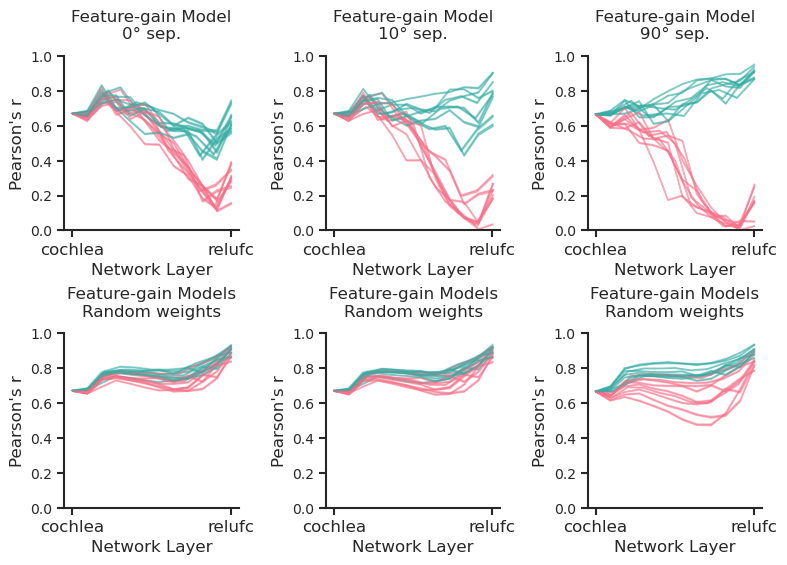

In [15]:
## Plot summary_results df 
sns.set_style('ticks')

# act_corrs
# df_for_agg.Stream.rename({'r_tgt_mixture': 'corr(target$_i$, mixture$_i$)', 'r_dist_mixture': 'corr(distractor$_i$, mixture$_i$)'}, inplace=True)

hue_order = ['corr(target$_i$, mixture$_i$)', 'corr(distractor$_i$, mixture$_i$)'] 
# make palette for models in husl 
palette = sns.color_palette("husl", 2)
# make palette dict 
palette_dict = {'corr(target$_i$, mixture$_i$)': palette[1],
                'corr(distractor$_i$, mixture$_i$)': palette[0],}

# add line style dict 
line_style_dict = {'corr(target$_i$, mixture$_i$)': '-',
                   'corr(distractor$_i$, mixture$_i$)': '-'}  
 
# col_wrap = 6

models = df_for_agg.model_name.unique()
n_models = len(models)


tgt_locs = df_for_agg.spatial_cond.unique()
n_cols = len(tgt_locs) # trained + rand 
n_rows = 2 # int(np.ceil(n_models / n_cols))
panel_height = 3
fontsize=12
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols* panel_height , n_rows*panel_height), sharex=False, sharey=False)
# axs = axs.flatten()


for i, model in enumerate(models):
    row_ix = 1 if 'rand' in model else 0 
    model_df = df_for_agg[df_for_agg['model_name'] == model]
    for axs_ix, loc in enumerate(tgt_locs):
        model_for_panel = model_df[model_df['spatial_cond'] == loc].set_index('layer')
        layers = [l for l in layer_order_dict[model] if 'cochlea' in l or 'relu' in l]
        try:
            model_for_panel = model_for_panel.loc[layers].reset_index()
            x_axis = np.linspace(0, 1, len(layers))
            for stream in model_for_panel.Stream.unique():
                stream_data = model_for_panel[model_for_panel['Stream'] == stream]
                axs[row_ix, axs_ix].errorbar(x_axis, stream_data['r'], yerr=stream_data['r_sem'], label=stream if axs_ix == 0 else None, alpha=0.1, color=palette_dict[stream])
                axs[row_ix, axs_ix].fill_between(x_axis, stream_data['r'] - stream_data['r_sem'], stream_data['r'] + stream_data['r_sem'], alpha=0.5, color=palette_dict[stream])
        except Exception as e:
            print(f"Error with {model}")
            print(e)
            continue
        if i == 0 :
            axs[0, axs_ix].set_title(f"Feature-gain Model\n{loc}", size=fontsize, y=1.05)
            axs[1, axs_ix].set_title("Feature-gain Models\nRandom weights", size=fontsize, y=1.05)

# make panels square 
# for ax in axs:
for ax in axs.ravel():
    ax.set_aspect('auto')
    ax.set_box_aspect(1)
    ax.set_ylim(0, 1)
    # ax.set_xlim(-0.5, len(layers) - 0.5)
    ax.set_xticks([0,1])
    ax.set_xticklabels(labels=['cochlea', 'relufc'], rotation=0, size=fontsize, )
    ax.set(ylim=(0,1))
    ax.set_xlabel("Network Layer", size=fontsize)
    ax.set_ylabel("Pearson's r", size=fontsize)
    # remove spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    ax.tick_params(axis='both', which='major', length=5, width=1.5)


# remove legend, and instead plot as colored text 
top_y_loc = .175
x_coord = -0.025

sns.despine()

# adjust spacing
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# plt.savefig(fig_out_dir / "figure_5_all_arch_traces_three_azims.pdf", transparent=True, bbox_inches='tight')

